<a href="https://colab.research.google.com/github/BioML-UGent/Advanced-AI-for-Bioinformatics/blob/main/06_calibration/PClab_6_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PC-Lab: Calibration of Machine Learning Models


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import make_classification, make_blobs
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

For this tutorial, we'll make use of the python package [pycalib](https://classifier-calibration.github.io/PyCalib/). It first has to installed into your environment.

In [2]:
!pip install pycalib
import pycalib

  Preparing metadata (setup.py) ... done
  Created wheel for pycalib: filename=pycalib-0.1.0.dev6-py3-none-any.whl size=37283 sha256=410fb4ec675290ee6583633cf2c5a0c4fd879bcbbb7a4c945ba54d8b21fbe418
  Stored in directory: /root/.cache/pip/wheels/db/bf/ea/6afc5c6734bb396fd469fd084fbc9c7bc8c34d70092d022389
Successfully built pycalib


## Introduction to Calibration in Machine Learning

In machine learning, uncertainty estimation is crucial for understanding the confidence level of model predictions.
 It involves quantifying the degree of certainty or doubt associated with a model's predictions.

## What is Calibration?

Calibration in machine learning refers to the process of aligning a model's predicted probabilities with the actual outcomes.
 A well-calibrated model provides probability estimates that match the true likelihood of an event occurring.
 For example, if a calibrated model predicts an event with 70% probability,
then approximately 70% of the predictions at this probability level should be correct.

### The Importance of Calibration

Calibration is essential for two main reasons:

- **Trustworthiness**: A calibrated model ensures _trustworthiness_ in its predictions, which is vital for decision-making processes.
- **Decision-making**: In some applications, decisions are made based on the predicted probabilities rather than the classification itself. Accurate probability estimates are, therefore, crucial.

### Assesing Model Calibration

1. **Calibration Curves**

<img src="https://www.researchgate.net/publication/368304257/figure/fig2/AS:11431281118358760@1675739847164/Example-of-a-calibration-curve-which-plots-the-observed-frequency-of-instances-belonging.ppm" width=400>

2. **Analytical Scores**, i.e. calibration error estimates that estimate confidence, classwise or strong notions of calibration

## 1. Binary dataset

In the first task, we will look at the simple case of binary classification, and compare the calibration of different classifier models
using calibration curves and the expected calibration error as ann error estimate.

In [3]:
from sklearn.datasets import make_blobs

dataset_binary = make_blobs(n_samples=10000, centers=5, n_features=2, random_state=42)

# make the dataset binary
dataset_binary[1][:] = dataset_binary[1] > 2


Visualise the dataset in a scatterplot:

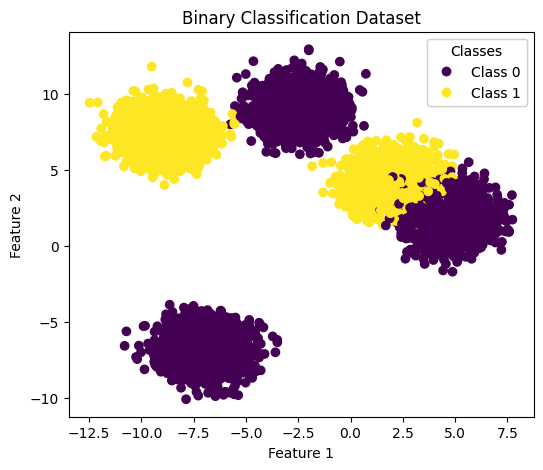

In [4]:
x, y = dataset_binary

fig, ax = plt.subplots(figsize=(6, 5))
scatter = ax.scatter(x[:, 0], x[:, 1], c=y, cmap='viridis')
handles, labels = scatter.legend_elements()
labels = ['Class 0', 'Class 1']

legend = ax.legend(handles, labels, loc="upper right", title="Classes")
ax.add_artist(legend)
plt.title('Binary Classification Dataset')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()



### Exercise 1
Split your training data into training and validation, use a bigger percentage (50 %) for testing the calibration afterwards. (Why??). Fit a simple Naive Bayes Classifier on your data.  


In [6]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

clf = GaussianNB()
clf.fit(x_train, y_train)

GaussianNB()

_Why choose a higher percentage for the test set_?
- higher reliability: more reliable and stable calibration estimates
- generalizability
- statisitical significance: more statistical power to detect differences/issues in calibration

### Exercise 2
Visualize the predicted probabilities of your classifier predicted for class 1 in dependence of the feature space using <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html" target="_top"> contour lines </a> and histograms. For the latter, use 10 equal-length bins to divide the predicted probabilities.


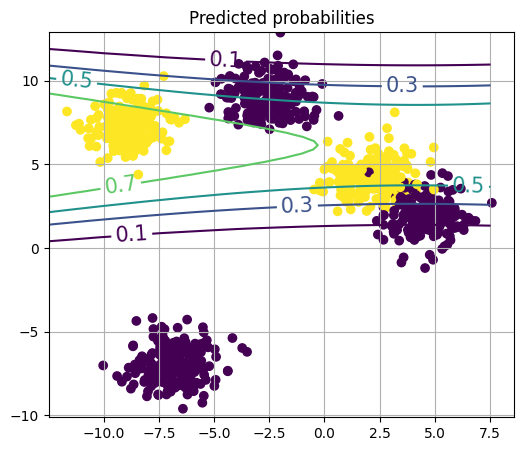

In [7]:
# divide the feature space into a grid
delta = 0.25
x0_grid = np.arange(x[:, 0].min(), x[:, 0].max(), delta)
x1_grid = np.arange(x[:, 1].min(), x[:, 1].max(), delta)
X0, X1 = np.meshgrid(x0_grid, x1_grid)
# predict the probabilities for each point on the grid
Y = clf.predict_proba(np.vstack((X0.flatten(), X1.flatten())).T)

fig, ax = plt.subplots(figsize=(6, 5))
# do a contour plot of the probabilities for class 1
CS = ax.contour(X0, X1, Y[:, 1].reshape(X0.shape), levels=[.1, .3, .5, .7, .9])
ax.clabel(CS, inline=1, fontsize=15)
ax.scatter(x_test[:1000, 0], x_test[:1000, 1], c=y_test[:1000])
ax.set_title('Predicted probabilities')
ax.grid()

We can also look at the positive scores the classifier gives to each sample.

Text(0, 0.5, 'Predicted probability')

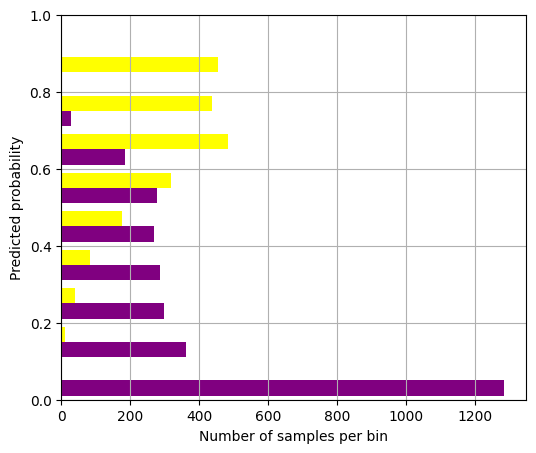

In [ ]:
# divide the scores into bins
n_bins = 10
bins = np.linspace(0, 1, n_bins + 1)

# predictions on test set
p_pred = clf.predict_proba(x_test)

fig, ax = plt.subplots(figsize=(6, 5))

ax.hist([p_pred[y_test == 0, 1], p_pred[y_test == 1, 1]], bins=bins, orientation='horizontal', label=['Class 0', 'Class 1'],
        color=["purple", "yellow"])
ax.set_ylim(0, 1)
ax.grid()
ax.set_xlabel('Number of samples per bin')
ax.set_ylabel('Predicted probability')

We see that the model gives lower scores to the first class, and that most of the instances of that class
are in the range of scores between $0$ and $0.1$. The last bin between $0.9$ and $1.0$ does not contain any sample.

### Exercise 3
Plot a reliability diagram. In order to do this, use a number of B=10 bins to divide the predicted probabilities Use the <a href="https://numpy.org/doc/stable/reference/generated/numpy.digitize.html" target="_top"> numpy.digitize </a> function to return the index of the corresponding bin for each instance. Compute the mean score for each bin and compare the true positive rate in each bin (i.e. the percentage of instances classified as 1).


In [ ]:
# assign each of the instances to a bin
bin_index = np.digitize(p_pred[:, 1], bins=bins)
print(bin_index)

# compute the mean score in each bin
pred_means = [p_pred[:, 1][bin_index == i].mean() for i in range(1, n_bins + 1)]
print(pred_means)

y_means = [y_test[bin_index == i].mean() for i in range(1, n_bins+1)]

[1 1 7 ... 9 1 6]
[np.float64(0.012432487052501908), np.float64(0.15203439630231722), np.float64(0.24868816147980233), np.float64(0.3514564346996101), np.float64(0.45029774080111806), np.float64(0.5534547383794531), np.float64(0.6486686394892508), np.float64(0.7595789271035308), np.float64(0.8238768795804186), np.float64(nan)]


/tmp/ipython-input-4017859286.py:6: RuntimeWarning: Mean of empty slice.
  pred_means = [p_pred[:, 1][bin_index == i].mean() for i in range(1, n_bins + 1)]
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipython-input-4017859286.py:9: RuntimeWarning: Mean of empty slice.
  y_means = [y_test[bin_index == i].mean() for i in range(1, n_bins+1)]


Now we can plot a line with the mean scores in the $x$ axis and the true positive rate on the $y$ axis.

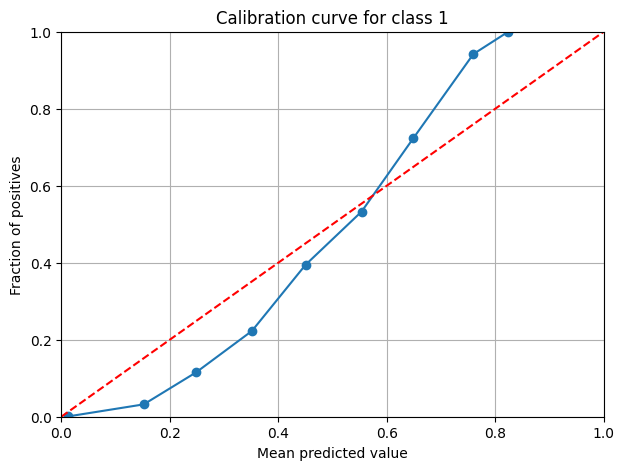

In [ ]:
fig, ax = plt.subplots( figsize=(7, 5))
ax.plot(pred_means, y_means, 'o-')
ax.plot([0, 1], [0, 1], 'r--')
ax.set_xlim(0, 1)
ax.set_xlabel('Mean predicted value')
ax.set_ylim(0, 1)
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration curve for class 1')
ax.grid()

We see that the model is

- _over-confident_ in the lower range of scores: predicts scores of 0.2 when the true proportion of positives is around 10%.
- _under-confident_ in the higher range of scores: predicts scores of 0.8 when the true proportion of positives is 100 %.

### Exercise 4
Train a KNN classifier on the data and compare the calibration to the NaiveBayes in a joint calibration curve plot. Use the pycalib.visualisations functions plot_reliability_diagram and plot_binary_reliability_diagram_gaps.


In [9]:
clf2 = KNeighborsClassifier(n_neighbors=10)
clf2.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In the PyCalib library we can directly call a function to plot the reliability diagram for a list of output scores. Use the function [```plot_reliability_diagrams```](https://classifier-calibration.github.io/PyCalib/api/visualisations.html#pycalib.visualisations.plot_reliability_diagram) to visualize the calibration curve for both classifiers.

/tmp/ipython-input-3976485919.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


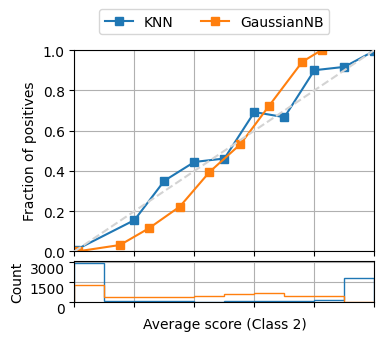

In [10]:
from pycalib.visualisations import plot_reliability_diagram

scores_list = [clf2.predict_proba(x_test), clf.predict_proba(x_test)]
labels_list = ['KNN', 'GaussianNB']

_ = plot_reliability_diagram(y_test, scores_list, legend=labels_list, show_histogram=True)
plt.tight_layout()

We can also compute the expected calibration error fro both classifiers:

In [11]:
from pycalib.metrics import ECE

ece_list = [ECE(y_test, scores) for scores in scores_list]
print(f"ECE for KNN: {ece_list[0]:.3f}")
print(f"ECE for GaussianNB: {ece_list[1]:.3f}")

ECE for KNN: 0.244
ECE for GaussianNB: 0.138


## 2. Multiclass Setting

Let's do the same analysis for a multiclass problem.

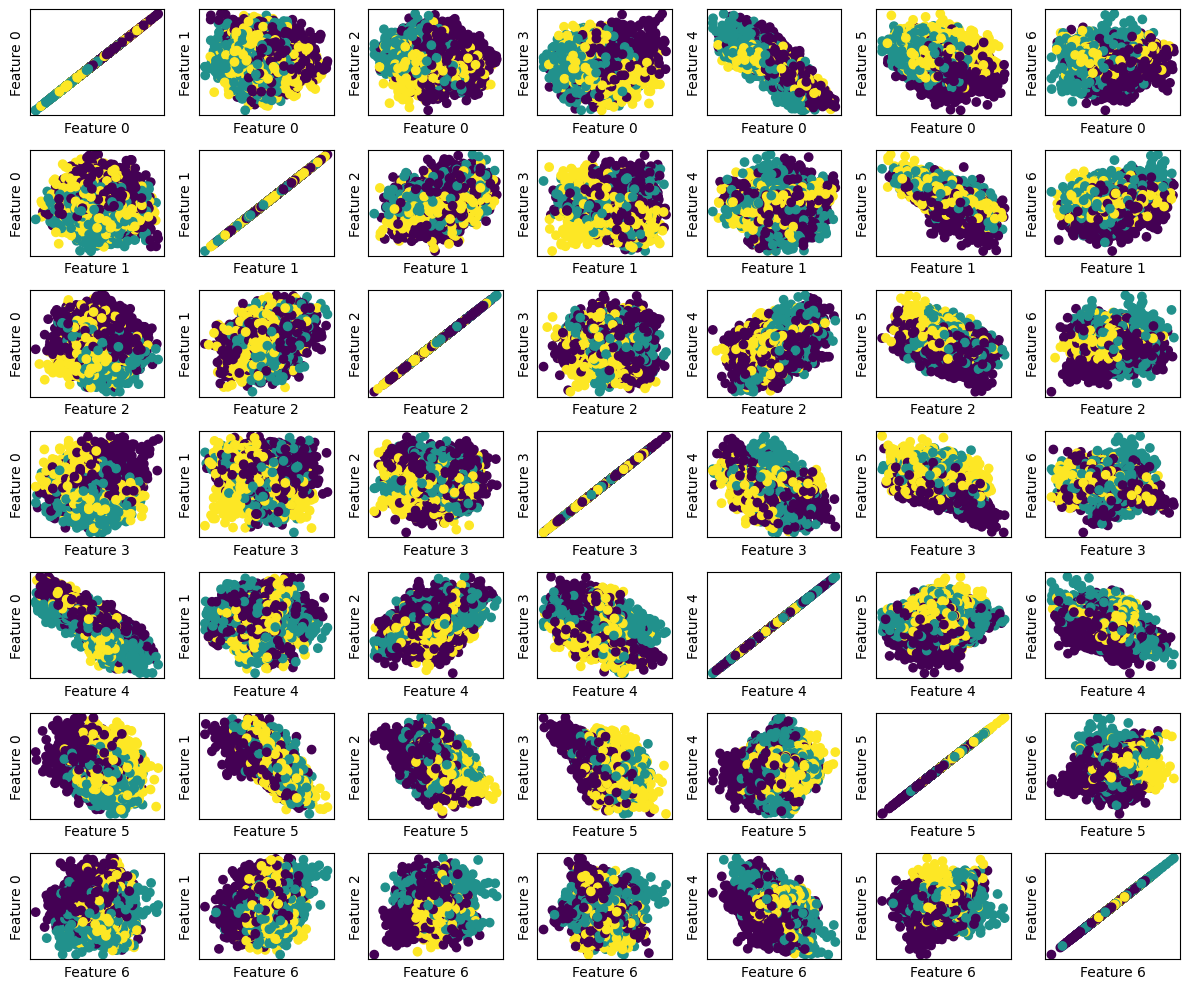

In [ ]:
n_features = 7
dataset_ternary = make_classification(n_classes=3, n_samples=10000, n_clusters_per_class=3, n_features=n_features, n_informative=5, random_state=42)

# visualize the dataset
x, y = dataset_ternary
fig, ax = plt.subplots(7, 7, figsize=(12, 10))

for i in range(n_features):
    for j in range(n_features):
        ax[i, j].scatter(x[:, i], x[:, j], c=y, cmap='viridis')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_xlabel(f'Feature {i}')
        ax[i, j].set_ylabel(f'Feature {j}')

plt.tight_layout()

### Exercise 5
Again train a Naive Bayes classifier and a k-nearest neighbor classifier with n=10 neighbors on your dataset. Plot the reliability curves for both of them. How do you evaluate calibration in the multi-class scenario?



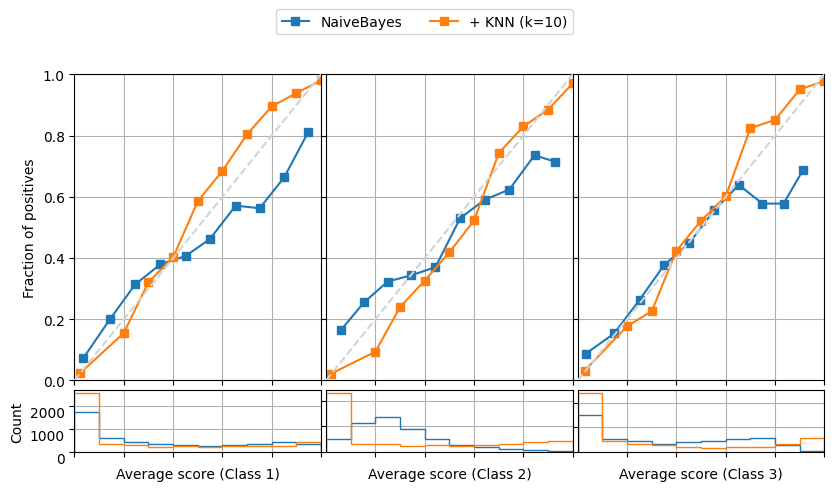

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
clf = GaussianNB()
clf.fit(x_train, y_train)
clf2 = KNeighborsClassifier(n_neighbors=10)
clf2.fit(x_train, y_train)

scores_list = [clf.predict_proba(x_test),
          clf2.predict_proba(x_test)]

fig = plt.figure(figsize=(10,6 ))
_ = plot_reliability_diagram(y_test, scores_list, legend=('NaiveBayes', '+ KNN (k=10)'),
                             show_histogram=True, fig=fig)

### Exercise 6
Calculate confidence and classwise ECE for both classifiers using the pre-implemented functions from pycalib.


In [ ]:
from pycalib.metrics import conf_ECE, classwise_ECE

print(f"Confidence ECE for NaiveBayes: {conf_ECE(y_test, scores_list[0]):.3f}")
print(f"Confidence ECE for KNN: {conf_ECE(y_test, scores_list[1]):.3f}")

print(f"Classwise ECE for NaiveBayes: {classwise_ECE(y_test, scores_list[0]):.3f}")
print(f"Classwise ECE for KNN: {classwise_ECE(y_test, scores_list[1]):.3f}")

Confidence ECE for NaiveBayes: 0.095
Confidence ECE for KNN: 0.024
Classwise ECE for NaiveBayes: 0.071
Classwise ECE for KNN: 0.033


## 3. Calibration Maps: Isotonic Regression

In the last section, we will look at two ways of calibrating the predictions of a model after it has been trained.

**Platt Scaling**, also known as logistic calibration, fits a logistic regression model to the classifier's output. In particular,

having a model $f$, the transformation $$P(y=1|x) = \frac{1}{1 + \exp(Af(x) + B)}$$ is used to logistically transform the scores.

On the other hand, **Isotonic Regression** works by fitting a non-decreasing functiion to the model's outputs, which is learned by minimizing a least-squares criterion on the calibration data.



We will load again the binary dataset that we created earlier, and use the Naive BAyes Classifier to compare the two methods.

In [ ]:
x, y = dataset_binary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

### Exercise 7

This time, use the sklearn class <a href="https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html" target="_top">CalibratedClassifierCV </a> to train three different classifiers: the uncalibrated naive Bayes, the naive Bayes with Platt scaling calibration and the naive Bayes with isotonic regression calibration.



In [ ]:
from sklearn.calibration import CalibratedClassifierCV

clf = GaussianNB()
clf.fit(x_train, y_train)

cal_clf_1 = CalibratedClassifierCV(GaussianNB(), method='sigmoid')
cal_clf_1.fit(x_train, y_train)

cal_clf_2 = CalibratedClassifierCV(GaussianNB(), method='isotonic')
cal_clf_2.fit(x_train, y_train)




CalibratedClassifierCV(estimator=GaussianNB(), method='isotonic')

### Exercise 8
Visualize the reliabiltiy diagram of all three classifiers.


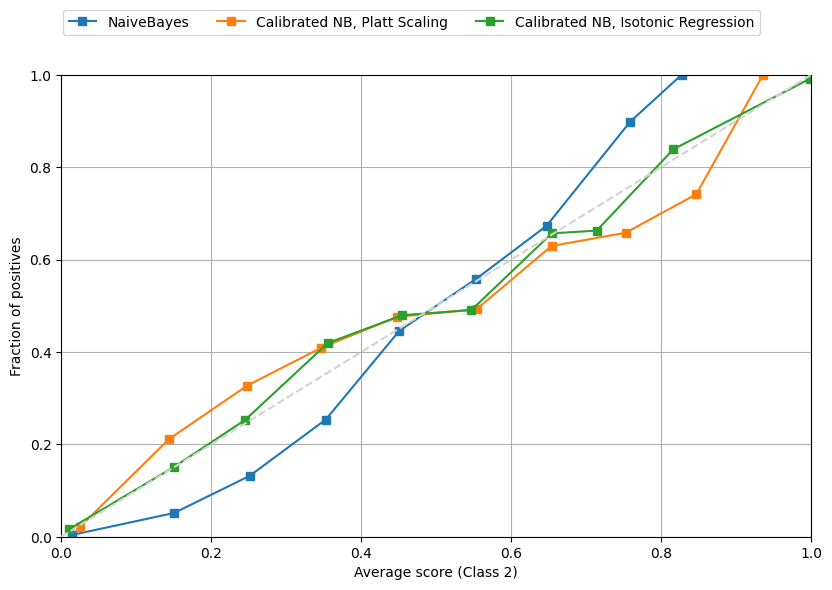

In [ ]:
fig = plt.figure(figsize=(10, 6))

_ = plot_reliability_diagram(y_test, [clf.predict_proba(x_test), cal_clf_1.predict_proba(x_test), cal_clf_2.predict_proba(x_test)],
                                legend=('NaiveBayes', 'Calibrated NB, Platt Scaling','Calibrated NB, Isotonic Regression'), show_histogram=False, fig=fig)

#### Comparison of the two calibration maps

Isotonic Regression is closer to the diagonal line.